# Model

The model is the reasoning engine of your agent. It can be specified in multiple ways, supporting both static and dynamic model selection.

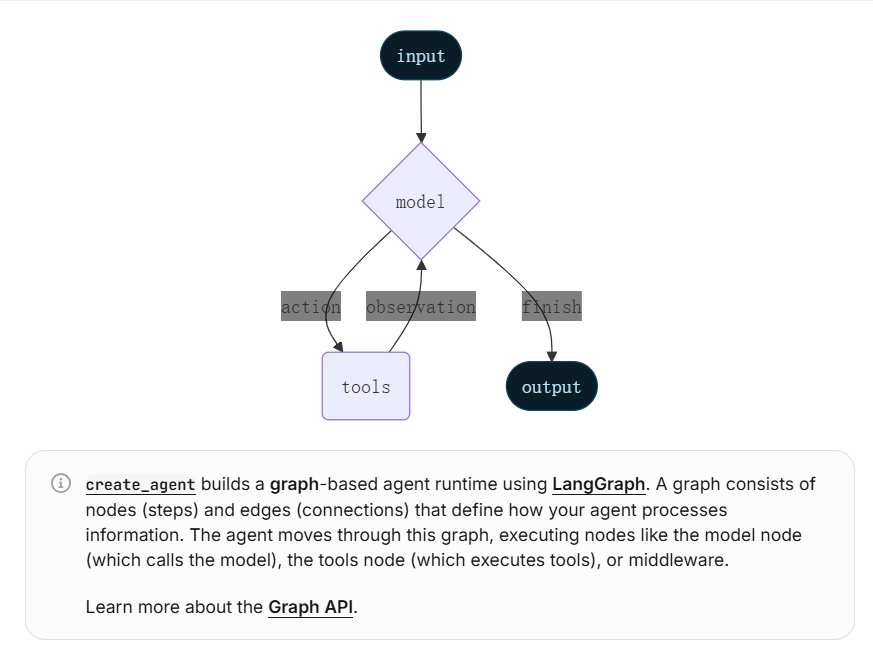

## Static model
Static models are configured once when creating the agent and remain unchanged throughout execution. This is the most common and straightforward approach.

In [1]:
# To initialize a static model from a model identifier string:
from langchain.agents import create_agent

tools=[]
agent = create_agent("gpt-5", tools=tools)



In [2]:
#For more control over the model configuration, initialize a model instance directly using the provider package. 
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

tools=[]
model = ChatOpenAI(
    model="gpt-5",
    temperature=0.1,
    max_tokens=1000,
    timeout=30
    # ... (other params)
)
agent = create_agent(model, tools=tools)

## Dynamic model
Dynamic models are selected at runtime based on the current state and context. This enables sophisticated routing logic and cost optimization.<br>
To use a dynamic model, create middleware using the **@wrap_model_call decorator** that modifies the model in the request:

| 组件                | 作用                                 |
| ----------------- | ---------------------------------- |
| `wrap_model_call` | 装饰器：拦截每一次模型调用                      |
| `ModelRequest`    | 包含当前请求的上下文（messages、state、model 等） |
| `ModelResponse`   | 模型返回的统一封装                          |
这套 middleware 机制让你**在模型被真正调用前做决策**

In [4]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


basic_model = ChatOpenAI(model="gpt-4o-mini")
advanced_model = ChatOpenAI(model="gpt-4o")

# 装饰器：拦截模型调用
# “在 Agent 每一次准备调用 LLM 时，先执行这个函数”
@wrap_model_call
# handler 是 LangChain 内部“真实模型调用逻辑”的封装
# handler 是一个 函数
# 它接收一个 ModelRequest
# 返回一个 ModelResponse
# 你可以理解为：
# handler = “如果我什么都不干，LangChain 原本会怎么调用模型”
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """Choose model based on conversation complexity."""

    # request.state["messages"] 是当前完整对话历史
    # 每一轮 user / assistant / tool 都算一条
    message_count = len(request.state["messages"])

    if message_count > 10:
        # Use an advanced model for longer conversations
        model = advanced_model
    else:
        model = basic_model
    # request.override(model=model)
    # 不修改原 request
    # 创建一个 “临时替换 model 的新 request”
    return handler(request.override(model=model))

agent = create_agent(
    model=basic_model,  # Default model
    tools=tools,
    # 每一次模型调用都会经过middleware=[dynamic_model_selection]这个函数
    # 可以堆叠多个 middleware（像 HTTP 中间件一样）
    middleware=[dynamic_model_selection]
)

# Tools

## Defining tools
Pass a list of tools to the agent.

In [5]:
from langchain.tools import tool
from langchain.agents import create_agent


@tool
def search(query: str) -> str:
    """Search for information."""
    return f"Results for: {query}"

@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    return f"Weather in {location}: Sunny, 72°F"

agent = create_agent(model, tools=[search, get_weather])

## Tool error handling
To customize how tool errors are handled, use the **@wrap_tool_call** decorator to create middleware:

In [13]:
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain.messages import ToolMessage

# wrap_tool_call = 拦截“工具被真正执行”的那一刻
@wrap_tool_call
def handle_tool_errors(request, handler):
    """Handle tool execution errors with custom messages."""
    try:
        return handler(request)
    except Exception as e:
        # Return a custom error message to the model
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent = create_agent(
    model="gpt-4o",
    tools=[search, get_weather],
    middleware=[handle_tool_errors]
)

The agent will return a ToolMessage with the custom error message when a tool fails:
```python
[
    ...
    ToolMessage(
        content="Tool error: Please check your input and try again. (division by zero)",
        tool_call_id="..."
    ),
    ...
]
```

# System prompt
You can shape how your agent approaches tasks by providing a prompt. The system_prompt parameter can be provided as a string or a SystemMessage.

In [11]:
agent = create_agent(
    model,
    tools,
    system_prompt="You are a helpful assistant. Be concise and accurate."
)

## Dynamic system prompt
For more advanced use cases where you need to modify the system prompt based on runtime context or agent state, you can use middleware.<br>
The **@dynamic_prompt decorator** creates middleware that generates system prompts based on the model request:

In [ ]:
from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest


class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """Generate system prompt based on user role."""
    user_role = request.runtime.context.get("user_role", "user")
    base_prompt = "You are a helpful assistant."

    if user_role == "expert":
        return f"{base_prompt} Provide detailed technical responses."
    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."

    return base_prompt

agent = create_agent(
    model="gpt-4o",
    tools=[web_search],
    middleware=[user_role_prompt],
    context_schema=Context
)

# The system prompt will be set dynamically based on context
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Explain machine learning"}]},
    context={"user_role": "expert"}
)

# invocation

You can invoke an agent by passing an update to its **State**.<br> 
All agents include **a sequence of messages** in their state; to invoke the agent, pass a new message:


In [15]:
agent = create_agent(
    model="gpt-4o",
    tools=[search, get_weather],
    middleware=[handle_tool_errors]
)

result = agent.invoke(
    {"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]}
)

## Structured output